In [1]:
#Importing bunch of libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import pickle
from keras.preprocessing import sequence
from keras.models import Sequential,Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.preprocessing.image


Using TensorFlow backend.


In [2]:
#Loading the descriptions for the images.
datatxt=open('D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_text\\Flickr8k.token.txt','r')
txt=datatxt.read()
datatxt.close()
descriptions={}
for line in txt.split('\n'):
    tokens=line.split(' ')
    if len(line)<2:     #Removing s occuring alone after removing apostrophe.
        continue
    img_name,img_desc=tokens[0],tokens[1:]
    img_without_ext=img_name.split('.')[0]
    img_desc=' '.join(img_desc)
    if img_without_ext not in descriptions:
        descriptions[img_without_ext]=list()
    descriptions[img_without_ext].append(img_desc)
print('Loaded:',len(descriptions))
    
    



Loaded: 8092


In [3]:
#Cleaning the descriptions by converting them into small case for uniformity,removing punctuation,removing numbers if occur any.
table=str.maketrans('','',string.punctuation)
for key,desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc=desc_list[i].split()
        desc=[word.lower() for word in desc]
        desc=[word.translate(table) for word in desc]
        desc=[word for word in desc if len(word)>1]
        desc=[word for word in desc if word.isalpha()]
        desc_list[i]=' '.join(desc)

    

In [33]:
#Creating vocabulary.
vocabulary=set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Vocab Size:',len(vocabulary))

Vocab Size: 8680


In [36]:
#Save descriptions to a file.
lines=list()
for key,dsc_list in descriptions.items():
    for dsc in dsc_list:
        lines.append(key+' '+dsc)
    data='\n'.join(lines)
    file=open('descriptions.txt','w')
    file.write(data)
    file.close()
    



In [95]:
all_train_files_list=os.listdir('D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset\\')
train_img_list=open('D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_text\\Flickr_8k.trainImages.txt','r').read().split('\n')
train_img_list=train_img_list[:-1]
test_img_list=open('D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_text\\Flickr_8k.testImages.txt','r').read().split('\n')
test_img_list=test_img_list[:-1]

train_descriptions={}
desc_file=open('descriptions.txt','r')
desc_file_content=desc_file.read()

for line in desc_file_content.split('\n'):
    tempsp=line.split(' ')
    img_name,img_desc=tempsp[0]+'.jpg',tempsp[1:]
    if img_name in train_img_list:
        if img_name not in train_descriptions:
            train_descriptions[img_name]=[]
        desc = 'startseq ' + ' '.join(img_desc) + ' endseq'
        train_descriptions[img_name].append(desc)
    





In [69]:
def preprocess(image_path):
    img=image.load_img(image_path,target_size=(299,299))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    return img

In [62]:
incep_model=InceptionV3(weights='imagenet')
incep_not_last_layer=Model(incep_model.input,incep_model.layers[-2].output)

96116736/96112376 [==============================] - 280s 3us/step


In [83]:
def extract_img_features(image):
    image=preprocess(image)
    feature_vecs=incep_not_last_layer.predict(image)
    feature_vecs=np.reshape(feature_vecs,feature_vecs.shape[1])
    return feature_vecs

encoded_train_imgs={}

for img_name in train_img_list:
    encoded_train_imgs[img_name]=extract_img_features('D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset\\'+img_name)
     




    

In [84]:
#Save encoded images.
with open('encoded_train_images.pkl','wb') as encoded_pickle:
    pickle.dump(encoded_train_imgs,encoded_pickle)

In [85]:
encoded_test_imgs={}
for img_name in test_img_list:
    encoded_test_imgs[img_name]=extract_img_features('D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset\\'+img_name)
    
#Save encoded images.
with open('encoded_test_images.pkl','wb') as encoded_pickle:
    pickle.dump(encoded_test_imgs,encoded_pickle)
    

In [86]:
train_features=pickle.load(open('encoded_train_images.pkl','rb'))
print(len(train_features))

6000


In [98]:
all_training_captions=[]
for key,val in train_descriptions.items():
    for dsc in val:
        all_training_captions.append(dsc)
len(all_training_captions)

30000

In [102]:
#Consider only the words which occur 10 times.
word_count_threshold = 10
word_counts = {}
n_sents = 0
for sent in all_training_captions:
    n_sents += 1
    for word in sent.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= word_count_threshold]
print("Vocab size=",len(vocab))


Vocab size= 1631


In [107]:
#Creating word to index and index to word mapping.
idx2word={}
word2idx={}

idx=1
for word in vocab:
    word2idx[word]=idx
    idx2word[idx]=word
    idx+=1
    
vocab_size=len(word2idx)+1
vocab_size
    

1632

In [108]:
all_desc=list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]

max_len=max(len(d.split()) for d in lines)
max_len
    

32

In [125]:
def batch_generator(descriptions,photos,wordtoidx,max_len,batch_size):
    vec,inseq,outseq=[],[],[]
    n=0
    while True:
        for key,dsc_list in descriptions.items():
            n+=1
            
            photo=photos[key]
            for dsc in dsc_list:
                sq=[word2idx[word] for word in dsc.split( ) if word in word2idx]
                
                for i in range(1,len(sq)):
                    in_sq,out_sq=sq[:i],sq[i]
                    in_sq=pad_sequences([in_sq],maxlen=max_len)[0]
                    
                    out_sq=to_categorical([out_sq],num_classes=vocab_size)[0]
                    vec.append(photo)
                    inseq.append(in_sq)
                    outseq.append(out_sq)
                if n==batch_size:
                    yield [[np.array(vec),np.array(inseq)],np.array(outseq)]
                    vec,inseq,outseq=[],[],[]
                    n=0
                    
                    
                
                

In [110]:
#Loading glove vectors.
embedding_index={}
f=open(os.path.join('D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\glove.6B\\glove.6B.200d.txt'),encoding='utf-8')

for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embedding_index[word]=coefs
f.close()
print('Num of word vecs=',len(embedding_index))

                    

Num of word vecs= 400000


In [115]:
embedding_dim = 200


embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word2idx.items():
   
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        
        embedding_matrix[i] = embedding_vector

In [112]:
#Lets build the model.

input1=Input(shape=(2048,))
do1=Dropout(0.5)(input1)
dl1=Dense(256,activation='relu')(do1)

input2=Input(shape=(max_len,))
emb1=Embedding(vocab_size,200,mask_zero=True)(input2)
do2=Dropout(0.5)(emb1)
ls1=LSTM(256)(do2)

dec1=add([dl1,ls1])
dec2=Dense(256,activation='relu')(dec1)
outputs=Dense(vocab_size,activation='softmax')(dec2)
model=Model(inputs=[input1,input2],outputs=outputs)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 200)      326400      input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [116]:
#Freezing the embedding layer during backpropagation.
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [128]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

for i in range(epochs):
    generator = batch_generator(train_descriptions, train_features, word2idx, max_len, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')



Epoch 1/1
2000/2000 [==============================] - 323s 162ms/step - loss: 3.3220
Epoch 1/1
2000/2000 [==============================] - 302s 151ms/step - loss: 3.1647
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 3.0613
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 2.9792
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 2.9143
Epoch 1/1
2000/2000 [==============================] - 281s 141ms/step - loss: 2.8621
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 2.8207
Epoch 1/1
2000/2000 [==============================] - 281s 141ms/step - loss: 2.7839
Epoch 1/1
2000/2000 [==============================] - 283s 141ms/step - loss: 2.7551
Epoch 1/1
2000/2000 [==============================] - 281s 140ms/step - loss: 2.7268


In [129]:
for i in range(epochs):
    generator = batch_generator(train_descriptions, train_features, word2idx, max_len, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 282s 141ms/step - loss: 2.7023
Epoch 1/1
2000/2000 [==============================] - 281s 140ms/step - loss: 2.6787
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 2.6599
Epoch 1/1
2000/2000 [==============================] - 281s 140ms/step - loss: 2.6427
Epoch 1/1
2000/2000 [==============================] - 282s 141ms/step - loss: 2.6283
Epoch 1/1
2000/2000 [==============================] - 284s 142ms/step - loss: 2.6128
Epoch 1/1
2000/2000 [==============================] - 281s 141ms/step - loss: 2.5971
Epoch 1/1
2000/2000 [==============================] - 283s 142ms/step - loss: 2.5892
Epoch 1/1
2000/2000 [==============================] - 281s 141ms/step - loss: 2.5756
Epoch 1/1
2000/2000 [==============================] - 281s 141ms/step - loss: 2.5658


In [130]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

for i in range(epochs):
    generator = batch_generator(train_descriptions, train_features, word2idx, max_len, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    

Epoch 1/1
1000/1000 [==============================] - 180s 180ms/step - loss: 2.5229
Epoch 1/1
1000/1000 [==============================] - 181s 181ms/step - loss: 2.4996
Epoch 1/1
1000/1000 [==============================] - 187s 187ms/step - loss: 2.4874
Epoch 1/1
1000/1000 [==============================] - 186s 186ms/step - loss: 2.4808
Epoch 1/1
1000/1000 [==============================] - 186s 186ms/step - loss: 2.4725
Epoch 1/1
1000/1000 [==============================] - 187s 187ms/step - loss: 2.4610
Epoch 1/1
1000/1000 [==============================] - 186s 186ms/step - loss: 2.4508
Epoch 1/1
1000/1000 [==============================] - 187s 187ms/step - loss: 2.4425
Epoch 1/1
1000/1000 [==============================] - 187s 187ms/step - loss: 2.4353
Epoch 1/1
1000/1000 [==============================] - 187s 187ms/step - loss: 2.4286


In [131]:
model.save_weights('./model_weights/model_30.h5')

In [132]:
model.load_weights('./model_weights/model_30.h5')


In [133]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [140]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word2idx[w] for w in in_text.split() if w in word2idx]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [135]:
images='D:\\Machine_Learning_Projects_and_tools\\Image-captioning\\Flickr8k\\Flickr8k_Dataset\\Flicker8k_Dataset\\'

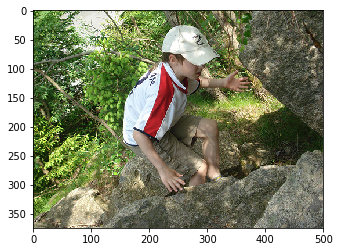

Greedy: man in red shirt attempts to climb rock face


In [152]:
z=43
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))